# Building an LSTM model to predict the price of the S&P 500

- LSTM stands for Long Short Term Memory

The LSTM cell contains an RNN cell inside (dense layer with a tanh activation function), but it has other attributes that allow it to remember patterns over a longer period of time. The LSTM contains a short-term state vector that is used from one time step to the next identical to the RNN cell.

Where LSTM cells differ is their Long-Term State vector. This long term state vector undergoes a multipicative and additive operation at each time step.The long term state vector starts off with a "forget gate" which is simply a sigmoid activation on top of a dense layer which produces an output from 0 - 1. This means if the forget gate ourputs a value of 1 then the long term state vector remains unchanged. On the opposite end, if the output valuse of the dense layer is 0 the long term state vector is nullified. This helps adjust quickly to highly volatile environments. If we are in a steady uptrend and then we suddenly have a big drop in the market, the long term state vector will be erased so the model can readjust quickly.

The next gate is the input gate. The input gate is much like the forget gate, except it decides if the short term state vector gets added to the long term vector or is erased. 

The last gate called the "output gate" decides what the next hidden state should be. It is important to know that this hidden state output is the prediction for the next time step. Here, the previous hidden state (previous cell output) amd current input are jammed together through sigmoid function. Then we take our newly modified long term state vector which has already passed through the forget and input gates, and apply a tanh function to it. Finally, multiple both the tanh output (long term state vector output) and the sigmoid function output (previous hidden state and new input at this time step) to what information the hidden state needs to carry to the next time step.

</br>
<b>To review, the Forget gate decides what is relevant to keep from prior steps. The input gate decides what information is relevant to add from the current step. The output gate determines what the next hidden state should be.</b>

## Setup

In [8]:
%pip install "keras==2.15.0" numpy pandas matplotlib tensorflow seaborn scikit-learn

INFO: pip is looking at multiple versions of tensorflow to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 4.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.7/205.7 MB 1.8 MB/s eta 0:00:0000:0100:03
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 2.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 2.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.2/189.2 kB 2.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.2/181.2 kB 2.2 MB/s eta 0:00:00a 0:00:01
Using cached rsa-4.9-py3-none-any.whl (34 kB)
Using cached oauthlib-3.2.2-py3-none-any.whl (151 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.3/85.3 kB 2.4 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

keras = tf.keras

# set style of charts
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [10, 10]

In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    

def sequential_window_dataset(series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

In [5]:
# Read in data
spy = pd.read_csv('../SPY.csv')

# Convert series into datetime type
spy['Date'] = pd.to_datetime(spy['Date'])

# Save target series
series = spy['Close']

# Create train data set
train_split_date = '2014-12-31'
train_split_index = np.where(spy.Date == train_split_date)[0][0]
x_train = spy.loc[spy['Date'] <= train_split_date]['Close']

# Create test data set
test_split_date = '2019-01-02'
test_split_index = np.where(spy.Date == test_split_date)[0][0]
x_test = spy.loc[spy['Date'] >= test_split_date]['Close']

# Create valid data set
valid_split_index = (train_split_index.max(),test_split_index.min())
x_valid = spy.loc[(spy['Date'] < test_split_date) & (spy['Date'] > train_split_date)]['Close']

5521 5522 6527 6528 6949


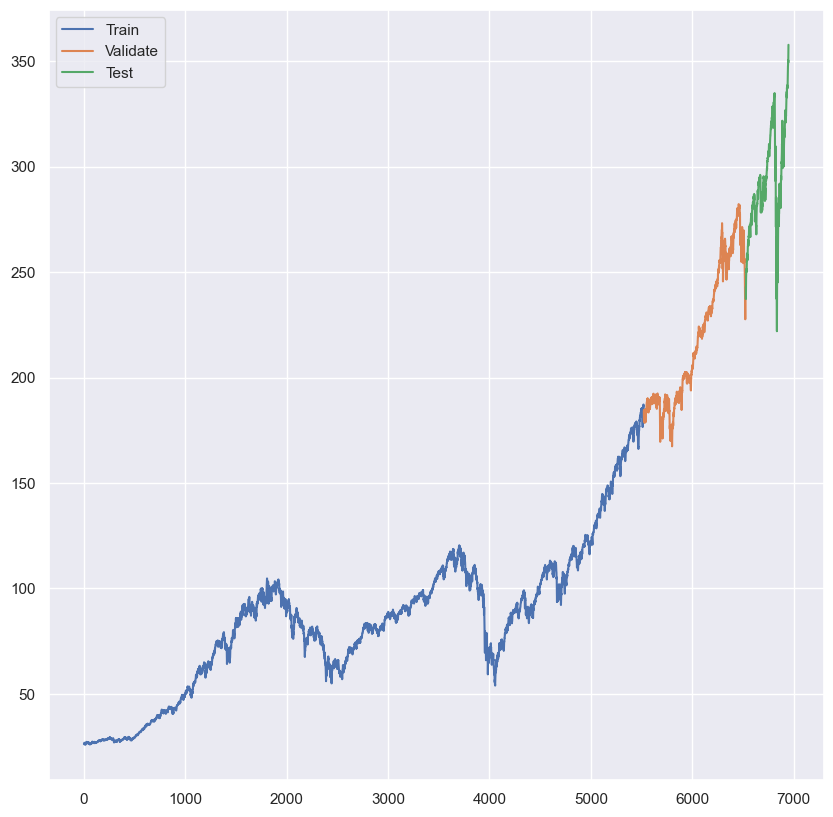

In [6]:
# Plot all lines on one chart to see where one segment starts and another ends
plt.plot(x_train, label = 'Train')
plt.plot(x_valid, label = 'Validate')
plt.plot(x_test, label = 'Test')
plt.legend()
print(x_train.index.max(),x_valid.index.min(),x_valid.index.max(),x_test.index.min(),x_test.index.max())

In [7]:
# Reshape values
x_train_values = x_train.values.reshape(-1, 1)
x_valid_values = x_valid.values.reshape(-1, 1)
x_test_values = x_test.values.reshape(-1, 1)

#  Create Scaler Object
x_train_scaler = MinMaxScaler(feature_range=(0, 1))

# Fit x_train values
normalized_x_train = x_train_scaler.fit_transform(x_train_values)

# Fit x_valid values
normalized_x_valid = x_train_scaler.transform(x_valid_values)

# Fit x_test values
normalized_x_test = x_train_scaler.transform(x_test_values)

# All values normalized to training data
spy_normalized_to_traindata = x_train_scaler.transform(series.values.reshape(-1, 1))

# Example of how to iverse
# inversed = scaler.inverse_transform(normalized_x_train).flatten()

In [8]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

## Find the learning Rate

In [11]:
# reset any stored data
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# Set window size and create input batch sequences
window_size = 20
train_set = sequential_window_dataset(normalized_x_train, window_size)

# create model
model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                    batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
])

# create lr
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 20))
reset_states = ResetStatesCallback()

# choose optimizer
# WARNING:absl:At this time, the v2.11+ optimizer `tf.keras.optimizers.Nadam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Nadam`.
# WARNING:absl:`lr` is deprecated in Keras optimizer, please use `learning_rate` or use the legacy optimizer, e.g.,tf.keras.optimizers.legacy.Nadam.
# optimizer = keras.optimizers.Nadam(lr=1e-5)
optimizer = keras.optimizers.legacy.Nadam(learning_rate=1e-5)

# compile model
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# set history
history = model.fit(train_set, epochs=100,
                    callbacks=[lr_schedule, reset_states])

Epoch 1/100
276/276 [==============================] - 3s 6ms/step - loss: 0.0103 - mae: 0.1146 - lr: 1.0000e-05
Epoch 2/100
276/276 [==============================] - 2s 6ms/step - loss: 6.8224e-04 - mae: 0.0266 - lr: 1.1220e-05
Epoch 3/100
276/276 [==============================] - 2s 6ms/step - loss: 4.5199e-04 - mae: 0.0220 - lr: 1.2589e-05
Epoch 4/100
276/276 [==============================] - 2s 7ms/step - loss: 3.1139e-04 - mae: 0.0189 - lr: 1.4125e-05
Epoch 5/100
276/276 [==============================] - 2s 6ms/step - loss: 2.3049e-04 - mae: 0.0167 - lr: 1.5849e-05
Epoch 6/100
276/276 [==============================] - 2s 6ms/step - loss: 1.8736e-04 - mae: 0.0152 - lr: 1.7783e-05
Epoch 7/100
276/276 [==============================] - 2s 6ms/step - loss: 1.6513e-04 - mae: 0.0143 - lr: 1.9953e-05
Epoch 8/100
276/276 [==============================] - 2s 7ms/step - loss: 1.5336e-04 - mae: 0.0136 - lr: 2.2387e-05
Epoch 9/100
276/276 [==============================] - 2s 6ms/step -

(1e-08, 1.0, 0.0, 0.01)

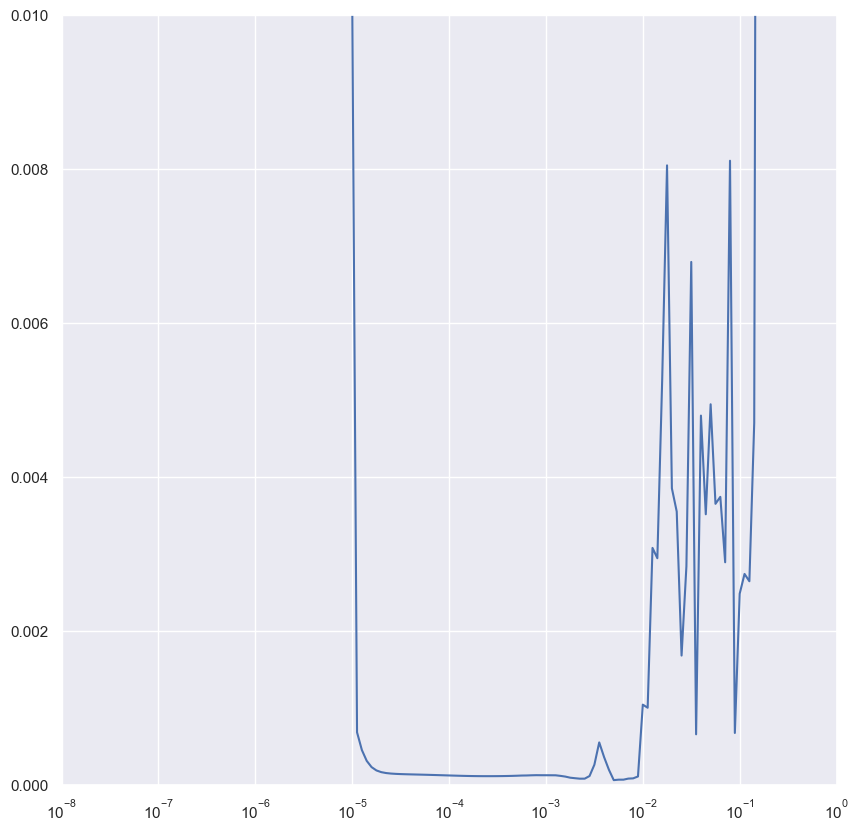

In [12]:
# Plot the learning rate chart
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1, 0, 0.01])

## Build and Train LSTM Model

In [14]:
# reset any stored data
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# set window size and create input batch sequence
window_size = 30
train_set = sequential_window_dataset(normalized_x_train, window_size)
valid_set = sequential_window_dataset(normalized_x_valid, window_size)

# create model
model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
])

# set optimizer
optimizer = keras.optimizers.legacy.Nadam(learning_rate=1e-4)

# compile model
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# reset states
reset_states = ResetStatesCallback()

#set up save best only checkpoint
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint", save_best_only=True)

early_stopping = keras.callbacks.EarlyStopping(patience=50)

# fit model
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint, reset_states])

Epoch 1/500
    184/Unknown - 3s 9ms/step - loss: 2.0827e-04 - mae: 0.0147INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


184/184 [==============================] - 5s 20ms/step - loss: 2.0827e-04 - mae: 0.0147 - val_loss: 0.0043 - val_mae: 0.0708
Epoch 2/500
183/184 [============================>.] - ETA: 0s - loss: 3.2508e-04 - mae: 0.0169INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


184/184 [==============================] - 4s 20ms/step - loss: 3.2421e-04 - mae: 0.0168 - val_loss: 0.0018 - val_mae: 0.0452
Epoch 3/500
183/184 [============================>.] - ETA: 0s - loss: 1.4585e-04 - mae: 0.0126INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


184/184 [==============================] - 4s 19ms/step - loss: 1.4622e-04 - mae: 0.0126 - val_loss: 0.0011 - val_mae: 0.0346
Epoch 4/500
183/184 [============================>.] - ETA: 0s - loss: 1.1867e-04 - mae: 0.0113INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


184/184 [==============================] - 4s 20ms/step - loss: 1.1933e-04 - mae: 0.0113 - val_loss: 8.5042e-04 - val_mae: 0.0315
Epoch 5/500
181/184 [============================>.] - ETA: 0s - loss: 1.0726e-04 - mae: 0.0106INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


184/184 [==============================] - 3s 18ms/step - loss: 1.1153e-04 - mae: 0.0108 - val_loss: 7.7770e-04 - val_mae: 0.0302
Epoch 6/500
183/184 [============================>.] - ETA: 0s - loss: 1.0543e-04 - mae: 0.0105INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


184/184 [==============================] - 4s 20ms/step - loss: 1.0609e-04 - mae: 0.0105 - val_loss: 7.3844e-04 - val_mae: 0.0294
Epoch 7/500
183/184 [============================>.] - ETA: 0s - loss: 1.0078e-04 - mae: 0.0102INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


184/184 [==============================] - 3s 19ms/step - loss: 1.0141e-04 - mae: 0.0103 - val_loss: 7.1141e-04 - val_mae: 0.0288
Epoch 8/500
179/184 [============================>.] - ETA: 0s - loss: 9.3850e-05 - mae: 0.0099INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


184/184 [==============================] - 3s 19ms/step - loss: 9.7183e-05 - mae: 0.0100 - val_loss: 6.9105e-04 - val_mae: 0.0282
Epoch 9/500
183/184 [============================>.] - ETA: 0s - loss: 9.2758e-05 - mae: 0.0098INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


184/184 [==============================] - 4s 21ms/step - loss: 9.3322e-05 - mae: 0.0098 - val_loss: 6.7668e-04 - val_mae: 0.0278
Epoch 10/500
181/184 [============================>.] - ETA: 0s - loss: 8.7125e-05 - mae: 0.0095INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


184/184 [==============================] - 3s 19ms/step - loss: 8.9766e-05 - mae: 0.0097 - val_loss: 6.6919e-04 - val_mae: 0.0276
Epoch 11/500
183/184 [============================>.] - ETA: 0s - loss: 8.5964e-05 - mae: 0.0094INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


184/184 [==============================] - 4s 20ms/step - loss: 8.6485e-05 - mae: 0.0095 - val_loss: 6.6770e-04 - val_mae: 0.0274
Epoch 12/500
183/184 [============================>.] - ETA: 0s - loss: 8.2964e-05 - mae: 0.0093INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


184/184 [==============================] - 4s 19ms/step - loss: 8.3477e-05 - mae: 0.0093 - val_loss: 6.6526e-04 - val_mae: 0.0273
Epoch 13/500
184/184 [==============================] - ETA: 0s - loss: 8.0769e-05 - mae: 0.0091INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


184/184 [==============================] - 4s 20ms/step - loss: 8.0769e-05 - mae: 0.0091 - val_loss: 6.4696e-04 - val_mae: 0.0269
Epoch 14/500
183/184 [============================>.] - ETA: 0s - loss: 7.7849e-05 - mae: 0.0090INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


184/184 [==============================] - 3s 19ms/step - loss: 7.8407e-05 - mae: 0.0090 - val_loss: 5.9984e-04 - val_mae: 0.0261
Epoch 15/500
181/184 [============================>.] - ETA: 0s - loss: 7.4214e-05 - mae: 0.0088INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


184/184 [==============================] - 3s 19ms/step - loss: 7.6407e-05 - mae: 0.0089 - val_loss: 5.3651e-04 - val_mae: 0.0250
Epoch 16/500
183/184 [============================>.] - ETA: 0s - loss: 7.3944e-05 - mae: 0.0087INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


184/184 [==============================] - 4s 21ms/step - loss: 7.4628e-05 - mae: 0.0088 - val_loss: 4.8811e-04 - val_mae: 0.0241
Epoch 17/500
182/184 [============================>.] - ETA: 0s - loss: 7.0855e-05 - mae: 0.0085INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


184/184 [==============================] - 4s 19ms/step - loss: 7.2801e-05 - mae: 0.0086 - val_loss: 4.6078e-04 - val_mae: 0.0235
Epoch 18/500
182/184 [============================>.] - ETA: 0s - loss: 6.8994e-05 - mae: 0.0084INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


184/184 [==============================] - 4s 20ms/step - loss: 7.0914e-05 - mae: 0.0085 - val_loss: 4.4195e-04 - val_mae: 0.0230
Epoch 19/500
179/184 [============================>.] - ETA: 0s - loss: 6.6992e-05 - mae: 0.0082INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


184/184 [==============================] - 4s 19ms/step - loss: 6.9191e-05 - mae: 0.0084 - val_loss: 4.2574e-04 - val_mae: 0.0226
Epoch 20/500
181/184 [============================>.] - ETA: 0s - loss: 6.5506e-05 - mae: 0.0081INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


184/184 [==============================] - 3s 18ms/step - loss: 6.7612e-05 - mae: 0.0083 - val_loss: 4.1155e-04 - val_mae: 0.0223
Epoch 21/500
182/184 [============================>.] - ETA: 0s - loss: 6.4279e-05 - mae: 0.0081INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


184/184 [==============================] - 4s 21ms/step - loss: 6.6123e-05 - mae: 0.0082 - val_loss: 3.9891e-04 - val_mae: 0.0219
Epoch 22/500
184/184 [==============================] - ETA: 0s - loss: 6.4741e-05 - mae: 0.0081INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


184/184 [==============================] - 4s 19ms/step - loss: 6.4741e-05 - mae: 0.0081 - val_loss: 3.8754e-04 - val_mae: 0.0216
Epoch 23/500
181/184 [============================>.] - ETA: 0s - loss: 6.1465e-05 - mae: 0.0079INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


184/184 [==============================] - 4s 22ms/step - loss: 6.3446e-05 - mae: 0.0080 - val_loss: 3.7731e-04 - val_mae: 0.0214
Epoch 24/500
179/184 [============================>.] - ETA: 0s - loss: 6.0210e-05 - mae: 0.0078INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


184/184 [==============================] - 3s 19ms/step - loss: 6.2241e-05 - mae: 0.0079 - val_loss: 3.6804e-04 - val_mae: 0.0211
Epoch 25/500
181/184 [============================>.] - ETA: 0s - loss: 5.9210e-05 - mae: 0.0077INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


184/184 [==============================] - 4s 20ms/step - loss: 6.1110e-05 - mae: 0.0078 - val_loss: 3.5975e-04 - val_mae: 0.0209
Epoch 26/500
183/184 [============================>.] - ETA: 0s - loss: 5.9294e-05 - mae: 0.0077INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


184/184 [==============================] - 3s 19ms/step - loss: 6.0058e-05 - mae: 0.0077 - val_loss: 3.5217e-04 - val_mae: 0.0207
Epoch 27/500
182/184 [============================>.] - ETA: 0s - loss: 5.7377e-05 - mae: 0.0076INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


184/184 [==============================] - 4s 21ms/step - loss: 5.9067e-05 - mae: 0.0077 - val_loss: 3.4565e-04 - val_mae: 0.0206
Epoch 28/500
184/184 [==============================] - ETA: 0s - loss: 5.8145e-05 - mae: 0.0076INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


184/184 [==============================] - 3s 18ms/step - loss: 5.8145e-05 - mae: 0.0076 - val_loss: 3.3924e-04 - val_mae: 0.0204
Epoch 29/500
179/184 [============================>.] - ETA: 0s - loss: 5.5409e-05 - mae: 0.0074INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


184/184 [==============================] - 3s 19ms/step - loss: 5.7268e-05 - mae: 0.0076 - val_loss: 3.3482e-04 - val_mae: 0.0203
Epoch 30/500
184/184 [==============================] - ETA: 0s - loss: 5.6464e-05 - mae: 0.0075INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


184/184 [==============================] - 4s 20ms/step - loss: 5.6464e-05 - mae: 0.0075 - val_loss: 3.2808e-04 - val_mae: 0.0201
Epoch 31/500
184/184 [==============================] - 2s 10ms/step - loss: 5.5669e-05 - mae: 0.0074 - val_loss: 3.2888e-04 - val_mae: 0.0203
Epoch 32/500
180/184 [============================>.] - ETA: 0s - loss: 5.3153e-05 - mae: 0.0073INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


184/184 [==============================] - 3s 19ms/step - loss: 5.4987e-05 - mae: 0.0074 - val_loss: 3.1510e-04 - val_mae: 0.0196
Epoch 33/500
184/184 [==============================] - 2s 10ms/step - loss: 5.4220e-05 - mae: 0.0073 - val_loss: 3.4710e-04 - val_mae: 0.0212
Epoch 34/500
184/184 [==============================] - 2s 10ms/step - loss: 5.3859e-05 - mae: 0.0073 - val_loss: 3.2379e-04 - val_mae: 0.0191
Epoch 35/500
184/184 [==============================] - 2s 10ms/step - loss: 5.3136e-05 - mae: 0.0072 - val_loss: 6.0936e-04 - val_mae: 0.0300
Epoch 36/500
184/184 [==============================] - 2s 10ms/step - loss: 5.6539e-05 - mae: 0.0076 - val_loss: 0.0012 - val_mae: 0.0426
Epoch 37/500
184/184 [==============================] - 2s 10ms/step - loss: 4.8873e-05 - mae: 0.0071 - val_loss: 4.3818e-04 - val_mae: 0.0229
Epoch 38/500
184/184 [==============================] - 2s 10ms/step - loss: 5.6416e-05 - mae: 0.0077 - val_loss: 3.7665e-04 - val_mae: 0.0207
Epoch 39/500
184

INFO:tensorflow:Assets written to: my_checkpoint/assets


184/184 [==============================] - 4s 20ms/step - loss: 3.7623e-05 - mae: 0.0062 - val_loss: 3.0991e-04 - val_mae: 0.0207
Epoch 70/500
182/184 [============================>.] - ETA: 0s - loss: 4.1682e-05 - mae: 0.0066INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


184/184 [==============================] - 3s 18ms/step - loss: 4.2316e-05 - mae: 0.0067 - val_loss: 3.0169e-04 - val_mae: 0.0185
Epoch 71/500
184/184 [==============================] - 2s 10ms/step - loss: 3.6941e-05 - mae: 0.0061 - val_loss: 3.1122e-04 - val_mae: 0.0209
Epoch 72/500
184/184 [==============================] - ETA: 0s - loss: 4.1952e-05 - mae: 0.0067INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


184/184 [==============================] - 4s 21ms/step - loss: 4.1952e-05 - mae: 0.0067 - val_loss: 2.9448e-04 - val_mae: 0.0184
Epoch 73/500
184/184 [==============================] - 2s 10ms/step - loss: 3.6310e-05 - mae: 0.0061 - val_loss: 3.0113e-04 - val_mae: 0.0205
Epoch 74/500
181/184 [============================>.] - ETA: 0s - loss: 4.0958e-05 - mae: 0.0066INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


184/184 [==============================] - 3s 18ms/step - loss: 4.1441e-05 - mae: 0.0066 - val_loss: 2.8260e-04 - val_mae: 0.0180
Epoch 75/500
184/184 [==============================] - 2s 10ms/step - loss: 3.5678e-05 - mae: 0.0060 - val_loss: 3.0733e-04 - val_mae: 0.0208
Epoch 76/500
182/184 [============================>.] - ETA: 0s - loss: 4.0637e-05 - mae: 0.0066INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


184/184 [==============================] - 3s 18ms/step - loss: 4.1219e-05 - mae: 0.0066 - val_loss: 2.8138e-04 - val_mae: 0.0182
Epoch 77/500
184/184 [==============================] - 2s 10ms/step - loss: 3.5063e-05 - mae: 0.0060 - val_loss: 2.9135e-04 - val_mae: 0.0202
Epoch 78/500
183/184 [============================>.] - ETA: 0s - loss: 4.0325e-05 - mae: 0.0065INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


184/184 [==============================] - 8s 45ms/step - loss: 4.0621e-05 - mae: 0.0066 - val_loss: 2.7088e-04 - val_mae: 0.0178
Epoch 79/500
184/184 [==============================] - 3s 19ms/step - loss: 3.4497e-05 - mae: 0.0059 - val_loss: 3.1464e-04 - val_mae: 0.0212
Epoch 80/500
184/184 [==============================] - 3s 17ms/step - loss: 4.0772e-05 - mae: 0.0066 - val_loss: 2.8262e-04 - val_mae: 0.0185
Epoch 81/500
183/184 [============================>.] - ETA: 0s - loss: 3.3162e-05 - mae: 0.0059INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


184/184 [==============================] - 6s 32ms/step - loss: 3.3906e-05 - mae: 0.0059 - val_loss: 2.7000e-04 - val_mae: 0.0194
Epoch 82/500
181/184 [============================>.] - ETA: 0s - loss: 3.9196e-05 - mae: 0.0064INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


184/184 [==============================] - 4s 20ms/step - loss: 3.9594e-05 - mae: 0.0065 - val_loss: 2.5508e-04 - val_mae: 0.0172
Epoch 83/500
184/184 [==============================] - 2s 10ms/step - loss: 3.3567e-05 - mae: 0.0058 - val_loss: 3.7210e-04 - val_mae: 0.0234
Epoch 84/500
184/184 [==============================] - 2s 10ms/step - loss: 4.1185e-05 - mae: 0.0066 - val_loss: 2.7873e-04 - val_mae: 0.0189
Epoch 85/500
181/184 [============================>.] - ETA: 0s - loss: 3.2635e-05 - mae: 0.0059INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


184/184 [==============================] - 3s 19ms/step - loss: 3.3313e-05 - mae: 0.0059 - val_loss: 2.4465e-04 - val_mae: 0.0176
Epoch 86/500
183/184 [============================>.] - ETA: 0s - loss: 3.7311e-05 - mae: 0.0063INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


184/184 [==============================] - 4s 21ms/step - loss: 3.7591e-05 - mae: 0.0063 - val_loss: 1.8961e-04 - val_mae: 0.0147
Epoch 87/500
184/184 [==============================] - 2s 10ms/step - loss: 3.3489e-05 - mae: 0.0057 - val_loss: 4.8729e-04 - val_mae: 0.0275
Epoch 88/500
184/184 [==============================] - 2s 9ms/step - loss: 4.0380e-05 - mae: 0.0065 - val_loss: 2.1909e-04 - val_mae: 0.0169
Epoch 89/500
184/184 [==============================] - 2s 9ms/step - loss: 3.3798e-05 - mae: 0.0060 - val_loss: 2.5136e-04 - val_mae: 0.0171
Epoch 90/500
184/184 [==============================] - 2s 9ms/step - loss: 3.6600e-05 - mae: 0.0062 - val_loss: 2.0339e-04 - val_mae: 0.0152
Epoch 91/500
184/184 [==============================] - 2s 9ms/step - loss: 3.2398e-05 - mae: 0.0057 - val_loss: 4.0902e-04 - val_mae: 0.0250
Epoch 92/500
184/184 [==============================] - 2s 11ms/step - loss: 3.8089e-05 - mae: 0.0063 - val_loss: 2.9542e-04 - val_mae: 0.0203
Epoch 93/500
184

INFO:tensorflow:Assets written to: my_checkpoint/assets


184/184 [==============================] - 3s 18ms/step - loss: 4.0843e-05 - mae: 0.0066 - val_loss: 1.7105e-04 - val_mae: 0.0149
Epoch 97/500
184/184 [==============================] - 2s 10ms/step - loss: 3.3361e-05 - mae: 0.0060 - val_loss: 2.5308e-04 - val_mae: 0.0169
Epoch 98/500
184/184 [==============================] - 2s 10ms/step - loss: 3.4421e-05 - mae: 0.0060 - val_loss: 2.5729e-04 - val_mae: 0.0170
Epoch 99/500
184/184 [==============================] - 2s 9ms/step - loss: 3.0264e-05 - mae: 0.0055 - val_loss: 2.3257e-04 - val_mae: 0.0182
Epoch 100/500
184/184 [==============================] - 2s 9ms/step - loss: 3.3697e-05 - mae: 0.0059 - val_loss: 3.0279e-04 - val_mae: 0.0200
Epoch 101/500
184/184 [==============================] - 2s 9ms/step - loss: 3.1011e-05 - mae: 0.0056 - val_loss: 4.4501e-04 - val_mae: 0.0261
Epoch 102/500
184/184 [==============================] - 2s 9ms/step - loss: 4.3337e-05 - mae: 0.0068 - val_loss: 1.8957e-04 - val_mae: 0.0157
Epoch 103/500

INFO:tensorflow:Assets written to: my_checkpoint/assets


184/184 [==============================] - 3s 18ms/step - loss: 4.2881e-05 - mae: 0.0068 - val_loss: 1.1480e-04 - val_mae: 0.0115
Epoch 109/500
184/184 [==============================] - 2s 10ms/step - loss: 3.1744e-05 - mae: 0.0058 - val_loss: 2.2007e-04 - val_mae: 0.0158
Epoch 110/500
184/184 [==============================] - 2s 10ms/step - loss: 2.9699e-05 - mae: 0.0055 - val_loss: 2.6409e-04 - val_mae: 0.0175
Epoch 111/500
184/184 [==============================] - 2s 10ms/step - loss: 2.8111e-05 - mae: 0.0054 - val_loss: 2.8225e-04 - val_mae: 0.0179
Epoch 112/500
184/184 [==============================] - 2s 10ms/step - loss: 2.9148e-05 - mae: 0.0054 - val_loss: 2.5430e-04 - val_mae: 0.0192
Epoch 113/500
184/184 [==============================] - 2s 9ms/step - loss: 3.3684e-05 - mae: 0.0059 - val_loss: 6.4503e-04 - val_mae: 0.0320
Epoch 114/500
184/184 [==============================] - 2s 10ms/step - loss: 2.9703e-05 - mae: 0.0056 - val_loss: 2.9029e-04 - val_mae: 0.0186
Epoch 1

INFO:tensorflow:Assets written to: my_checkpoint/assets


184/184 [==============================] - 4s 21ms/step - loss: 3.2499e-05 - mae: 0.0057 - val_loss: 9.3264e-05 - val_mae: 0.0101
Epoch 155/500
184/184 [==============================] - 2s 10ms/step - loss: 2.6963e-05 - mae: 0.0053 - val_loss: 1.7993e-04 - val_mae: 0.0143
Epoch 156/500
184/184 [==============================] - 2s 10ms/step - loss: 2.4492e-05 - mae: 0.0050 - val_loss: 2.0043e-04 - val_mae: 0.0152
Epoch 157/500
184/184 [==============================] - 2s 10ms/step - loss: 2.3238e-05 - mae: 0.0048 - val_loss: 2.4910e-04 - val_mae: 0.0170
Epoch 158/500
184/184 [==============================] - 2s 10ms/step - loss: 2.3402e-05 - mae: 0.0048 - val_loss: 1.8833e-04 - val_mae: 0.0145
Epoch 159/500
184/184 [==============================] - 2s 10ms/step - loss: 2.5385e-05 - mae: 0.0050 - val_loss: 3.1246e-04 - val_mae: 0.0220
Epoch 160/500
184/184 [==============================] - 2s 10ms/step - loss: 3.1438e-05 - mae: 0.0057 - val_loss: 1.8997e-04 - val_mae: 0.0163
Epoch 

INFO:tensorflow:Assets written to: my_checkpoint/assets


184/184 [==============================] - 3s 19ms/step - loss: 3.2824e-05 - mae: 0.0059 - val_loss: 8.9729e-05 - val_mae: 0.0099
Epoch 177/500
184/184 [==============================] - 2s 10ms/step - loss: 2.6085e-05 - mae: 0.0052 - val_loss: 1.6456e-04 - val_mae: 0.0137
Epoch 178/500
184/184 [==============================] - 2s 10ms/step - loss: 2.3932e-05 - mae: 0.0049 - val_loss: 1.8035e-04 - val_mae: 0.0144
Epoch 179/500
184/184 [==============================] - 2s 10ms/step - loss: 2.2422e-05 - mae: 0.0047 - val_loss: 2.1522e-04 - val_mae: 0.0158
Epoch 180/500
184/184 [==============================] - 2s 9ms/step - loss: 2.2586e-05 - mae: 0.0047 - val_loss: 1.7179e-04 - val_mae: 0.0139
Epoch 181/500
184/184 [==============================] - 2s 10ms/step - loss: 2.3558e-05 - mae: 0.0048 - val_loss: 1.9906e-04 - val_mae: 0.0169
Epoch 182/500
184/184 [==============================] - 2s 10ms/step - loss: 2.7166e-05 - mae: 0.0052 - val_loss: 3.5881e-04 - val_mae: 0.0235
Epoch 1

INFO:tensorflow:Assets written to: my_checkpoint/assets


184/184 [==============================] - 4s 20ms/step - loss: 2.8511e-05 - mae: 0.0054 - val_loss: 7.8811e-05 - val_mae: 0.0091
Epoch 212/500
184/184 [==============================] - 2s 10ms/step - loss: 2.4234e-05 - mae: 0.0050 - val_loss: 1.2873e-04 - val_mae: 0.0121
Epoch 213/500
184/184 [==============================] - 3s 17ms/step - loss: 2.4038e-05 - mae: 0.0049 - val_loss: 1.4133e-04 - val_mae: 0.0128
Epoch 214/500
184/184 [==============================] - 3s 18ms/step - loss: 2.2291e-05 - mae: 0.0047 - val_loss: 1.6369e-04 - val_mae: 0.0139
Epoch 215/500
184/184 [==============================] - 3s 17ms/step - loss: 2.2401e-05 - mae: 0.0047 - val_loss: 1.5218e-04 - val_mae: 0.0132
Epoch 216/500
184/184 [==============================] - 3s 17ms/step - loss: 2.2441e-05 - mae: 0.0047 - val_loss: 1.0214e-04 - val_mae: 0.0109
Epoch 217/500
184/184 [==============================] - 3s 18ms/step - loss: 2.2621e-05 - mae: 0.0047 - val_loss: 8.7746e-05 - val_mae: 0.0097
Epoch 

## Make Predictions

In [15]:
# recall best model
model = keras.models.load_model("my_checkpoint")

In [16]:
# make predictions
rnn_forecast = model.predict(normalized_x_test[np.newaxis,:])
rnn_forecast = rnn_forecast.flatten()


1/1 [==============================] - 0s 323ms/step


In [17]:
# Example of how to invert
rnn_unscaled_forecast = x_train_scaler.inverse_transform(rnn_forecast.reshape(-1,1)).flatten()
rnn_unscaled_forecast.shape

(422,)

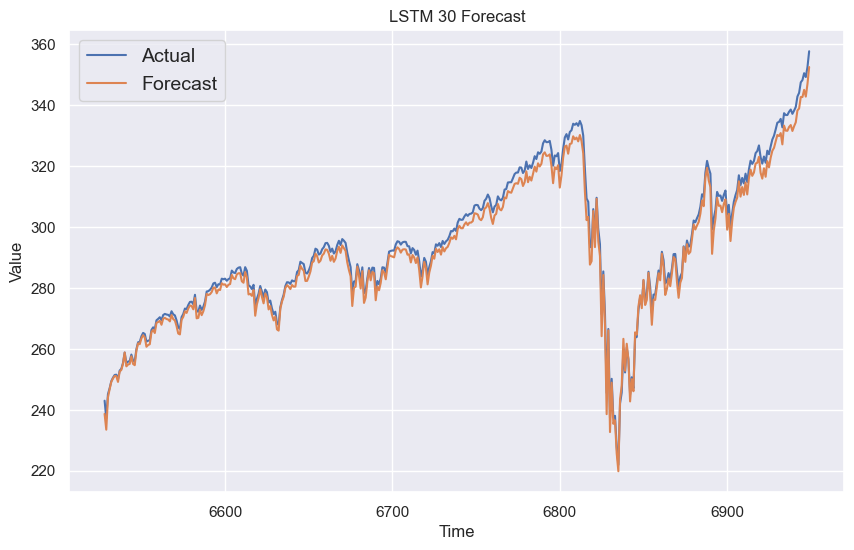

In [18]:
# plot results
plt.figure(figsize=(10,6))

plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plt.title(f'LSTM {window_size} Forecast')
plot_series(x_test.index, x_test, label="Actual")
plot_series(x_test.index, rnn_unscaled_forecast, label="Forecast")
plt.show()

In [19]:
# calculate MAE
keras.metrics.mean_absolute_error(x_test, rnn_unscaled_forecast).numpy()

2.5302558

MAE value in Blake's notebook was 1.1875452.  This value (2.53) seems quite a bit worse, at least in percentage change.
Is this due to library change or just expected variance for these runs?